In [18]:
%%html
<a href="https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/getting%20started.html">Referncing_URL</a>

In [1]:
from nvidia.dali.pipeline import Pipeline
help(Pipeline)

Help on class Pipeline in module nvidia.dali.pipeline:

class Pipeline(builtins.object)
 |  Pipeline class encapsulates all data required to define and run
 |  DALI input pipeline.
 |  
 |  Parameters
 |  ----------
 |  `batch_size` : int, optional, default = -1
 |      Batch size of the pipeline. Negative values for this parameter
 |      are invalid - the default value may only be used with
 |      serialized pipeline (the value stored in serialized pipeline
 |      is used instead).
 |  `num_threads` : int, optional, default = -1
 |      Number of CPU threads used by the pipeline.
 |      Negative values for this parameter are invalid - the default
 |      value may only be used with serialized pipeline (the value
 |      stored in serialized pipeline is used instead).
 |  `device_id` : int, optional, default = -1
 |      Id of GPU used by the pipeline.
 |      Negative values for this parameter are invalid - the default
 |      value may only be used with serialized pipeline (the v

In [2]:

from __future__ import print_function
import os.path
import fnmatch

for root, dir, files in os.walk("pic"):
        depth = root.count('/')
        ret = ""
        if depth > 0:
            ret += "  " * (depth - 1) + "|-"
        print (ret + root)
        for items in fnmatch.filter(files, "*"):
                print (" " * len(ret) + "|-" + items)

pic
|-pic/sky
  |-sky1.jpg
  |-sky0.jpg
  |-sky2.jpg
  |-sky6.jpg
  |-sky5.jpg
  |-sky3.jpg
  |-sky4.jpg
|-pic/nature
  |-nature1.jpg
  |-nature6.jpg
  |-nature5.JPG
  |-nature3.jpg
  |-nature2.jpg
  |-nature0.jpg
  |-nature4.jpg


### test a simple pipeline that does not much but reading the data + labels

In [4]:
import nvidia.dali.ops as ops
import nvidia.dali.types as types

image_dir = "pic"
batch_size = 8
seed = 1549361629

class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir)
        # instead of path to file directory file with pairs image_name image_label_value can be provided
        # self.input = ops.FileReader(file_root = image_dir, file_list = image_dir + '/file_list.txt')
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        
        return (images, labels)

In [5]:
pipe = SimplePipeline(batch_size, 1, 0)
pipe.build()

In [6]:
pipe_out = pipe.run()
print(pipe_out)
type(pipe_out[0])

(<nvidia.dali.backend_impl.TensorListCPU object at 0x7fe14e2de0d8>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7fe14e2de110>)


nvidia.dali.backend_impl.TensorListCPU

In [7]:

images, labels = pipe_out
print("Images is_dense_tensor: " + str(images.is_dense_tensor()))
print("Labels is_dense_tensor: " + str(labels.is_dense_tensor()))

Images is_dense_tensor: True
Labels is_dense_tensor: True


In [8]:
import numpy as np

labels_tensor = labels.as_tensor()
image_tensor= images.as_tensor()
print (labels_tensor.shape())
print (np.array(labels_tensor))
image_tensor.shape()

[8, 1]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]]


[8, 3024, 4032, 3]

In [9]:
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 2
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

In [ ]:

show_images(images)

### now we do rotate using pipeline 

In [12]:

class RotatedSimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(RotatedSimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir, random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)
        self.rotate = ops.Rotate(angle = 10.0)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        rotated_images = self.rotate(images)
        return (rotated_images, labels)

In [ ]:

pipe = RotatedSimplePipeline(batch_size, 1, 0)
pipe.build()

pipe_out = pipe.run()
images, labels = pipe_out
show_images(images)

### randomly slice the images 

In [ ]:
import numpy as np

class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __iter__(self):
        self.i = 0
        self.n = self.batch_size
        return self

    def __next__(self):
        pos = []
        size = []
        for _ in range(self.batch_size):
            pos.append(np.asarray([0.4, 0.2], dtype=np.float32))
            size.append(np.asarray([0.3, 0.5], dtype=np.float32))
            self.i = (self.i + 1) % self.n
        return (pos, size)

    next = __next__

eii = ExternalInputIterator(batch_size)
pos_size_iter = iter(eii)

class ImageDecoderSlicePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderSlicePipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)

        self.input = ops.FileReader(file_root = image_dir)
        self.input_crop_pos = ops.ExternalSource()
        self.input_crop_size = ops.ExternalSource()
        self.input_crop = ops.ExternalSource()
        self.decode = ops.ImageDecoderSlice(device = 'cpu', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        self.crop_pos = self.input_crop_pos()
        self.crop_size = self.input_crop_size()
        images = self.decode(jpegs, self.crop_pos, self.crop_size)
        return (images, labels)

    def iter_setup(self):
        (crop_pos, crop_size) = pos_size_iter.next()
        self.feed_input(self.crop_pos, crop_pos)
        self.feed_input(self.crop_size, crop_size)

pipe = ImageDecoderSlicePipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

### randomly crop the images

In [ ]:
class ImageDecoderRandomCropPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ImageDecoderRandomCropPipeline, self).__init__(batch_size, num_threads, device_id, seed = seed)
        self.input = ops.FileReader(file_root = image_dir)
        self.decode = ops.ImageDecoderRandomCrop(
            device="cpu",
            output_type=types.RGB,
            random_aspect_ratio=[0.8, 1.25],
            random_area=[0.1, 1.0],
            num_attempts=100)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        return (images, labels)

pipe = ImageDecoderRandomCropPipeline(batch_size, 1, 0)
pipe.build()
images, _ = pipe.run()
show_images( images )

### automatic image sharding 

In [16]:

class ShardedPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, shard_id, num_shards):
        super(ShardedPipeline, self).__init__(batch_size, num_threads, device_id)
        self.input = ops.FileReader(
            file_root = image_dir, random_shuffle = False, shard_id = shard_id, num_shards = num_shards)
        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)

        return (images, labels)

In [17]:
# Create and build pipelines
pipe_one = ShardedPipeline(batch_size, 1, device_id = 0, shard_id = 0, num_shards = 2)
pipe_one.build()


# Run pipelines
images_one, labels_one = pipe_one.run()


In [ ]:
show_images(images_one.as_cpu())

### automatically separate the color channels 

In [19]:
# define python operator for color seperation 
import numpy as np

def mix_and_split_channels(image1, image2):
    mixed = (image1 / 255. + image2 / 255.) / 2.
    return mixed[:, :, 0], mixed[:, :, 1], mixed[:, :, 2]

In [20]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import nvidia.dali.plugin.pytorch as dalitorch
import torch



class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, _seed, image_dir):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed=_seed, exec_async=False,
                                             exec_pipelined=False)
        self.input = ops.FileReader(file_root=image_dir)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
        self.flip = ops.Flip()
        self.mix_and_split = ops.PythonFunction(function=mix_and_split_channels, num_outputs=3)
        self.sqrt = dalitorch.TorchPythonFunction(function=lambda tensor: tensor.sqrt())

    def load(self):
        jpegs, labels = self.input()
        decoded = self.decode(jpegs)
        return decoded

    def define_graph(self):
        images1 = self.load()
        images2 = self.flip(images1)
        r, g, b = self.mix_and_split(images1, images2)
        return self.sqrt(r), g, b

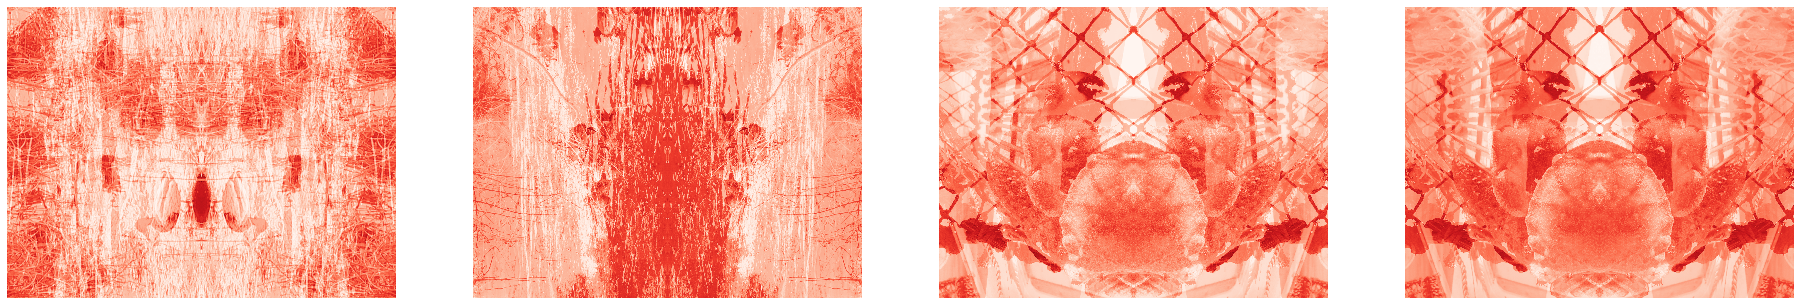

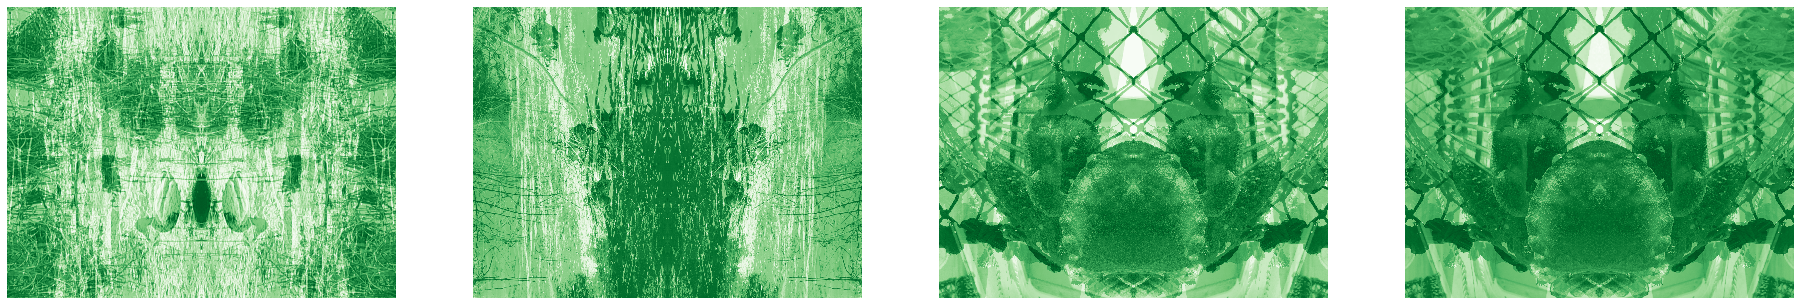

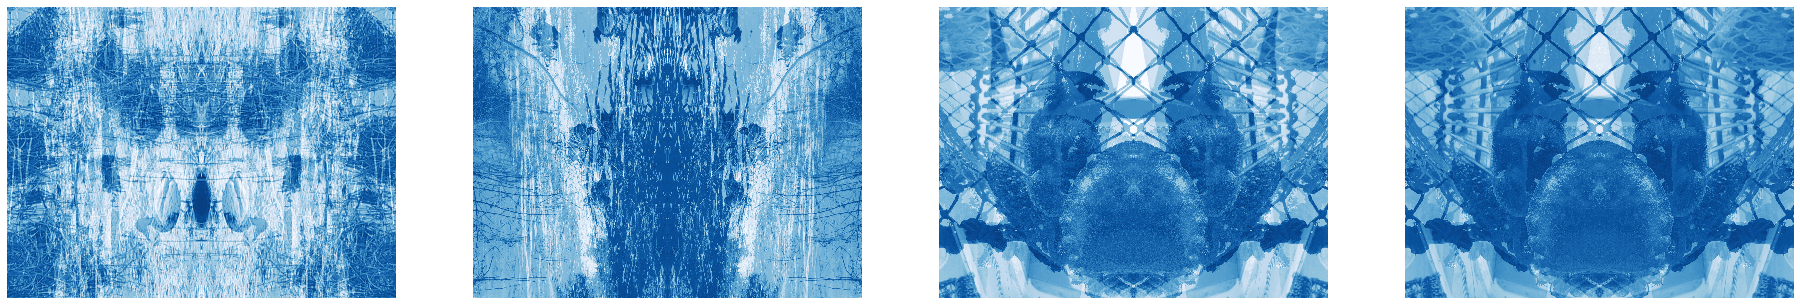

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline

batch_size=4

def show_images_color(image_batch, color_map):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j), cmap=plt.get_cmap(color_map))


pipe = SimplePipeline(batch_size, 4, 0, 12, image_dir)
pipe.build()
r, g, b = pipe.run()

show_images_color(r, 'Reds_r')
show_images_color(g, 'Greens_r')
show_images_color(b, 'Blues_r')